In [ ]:
!pip install autokeras==1.1.0 tensorflow==2.15.1 keras-nlp==0.5.1
!pip install keras==2.15

In [ ]:
import keras

In [ ]:
print(keras.__version__)

2.15.0


In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip

--2024-12-16 15:07:35--  https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1789636 (1.7M) [application/x-zip-compressed]
Saving to: ‘Sarcasm_Headlines_Dataset_v2.json.zip.2’

Sarcasm_Headlines_D 100%[===================>]   1.71M  1.54MB/s    in 1.1s    

2024-12-16 15:07:37 (1.54 MB/s) - ‘Sarcasm_Headlines_Dataset_v2.json.zip.2’ saved [1789636/1789636]



In [ ]:
!unzip -qo "Sarcasm_Headlines_Dataset_v2.json.zip" -d ./dataset

In [ ]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
# Библиотека для работы с регулярными выражениями
import re
import tensorflow as tf
# Библиотека AutoML autokeras
import autokeras as ak
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Необходимые метрики для построения Матрицы ошибок и отчета о классификации
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
address = "./dataset/Sarcasm_Headlines_Dataset_v2.json"
json_df = pd.read_json(address, lines = True )
df_sarcasm = pd.DataFrame(json_df)
df_sarcasm.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
df_sarcasm = df_sarcasm.drop("article_link", axis = 1)

In [ ]:
print('Найдено дубликатов: ', df_sarcasm.duplicated().sum())
df_sarcasm.drop_duplicates(subset=['headline'], inplace = True)
print('Осталось дубликатов после очистки: ', df_sarcasm.duplicated().sum())

Найдено дубликатов:  116
Осталось дубликатов после очистки:  0


In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df_sarcasm.headline),
                                                  np.array(df_sarcasm.is_sarcastic),
                                                  test_size=0.15)

X_val, X_test, y_val, y_test = train_test_split(X_tmp,
                                                  y_tmp,
                                                  test_size=0.5)

Text(0.5, 1.0, 'Число меток')

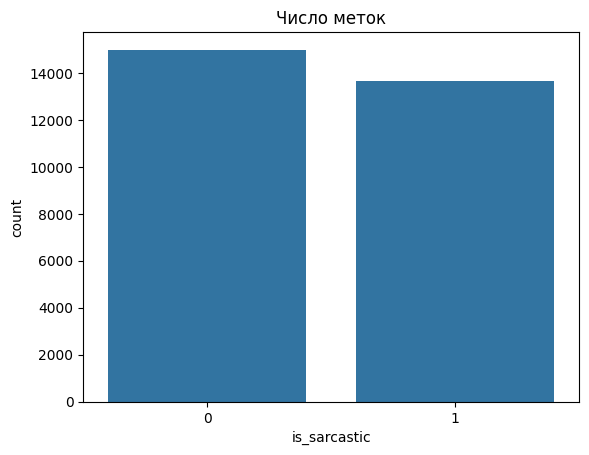

In [ ]:
f1 = sns.countplot(x='is_sarcastic', data=json_df);
f1.set_title("Число меток")

In [ ]:
print('Форма входных данных: ', X_train.shape)
print('Форма выходных меток: ', y_train.shape)
print('Пример заголовка: ', X_train[0])

Форма входных данных:  (24227,)
Форма выходных меток:  (24227,)
Пример заголовка:  man straight-up demands to know how many siblings coworker has


In [ ]:
# Для экономии ОЗУ удаляем уже ненужные данные, после чего python запускает сборщик "мусора" для очистки памяти
del df_sarcasm, X_tmp, y_tmp

In [ ]:
def plot_graphs(history, key):
    # Используем библиотеку seaborn для задания стиля и цветовой схемы графика
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')

    # Задаем размер полотна для рисования графика
    plt.figure(figsize=(12,6))

    # Отображаем график выбранного параметра
    plt.plot(history.history[key],   # данные для построения графика
             marker='o',             # использовать маркер для точек на графике
             color=palette[2],       # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          # ширина линии
             label=key)              # подпись легенды

    # График для проверочной выборки
    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], # данные для построения графика
                 marker='o',                  # использовать маркер для точек на графике
                 color=palette[4],            # использовать цвет пятый в палитре
                 linewidth=2.5,               # ширина линии
                 label='val_'+key)            # подпись легенды

    # подпись оси Х, размер шрифта - 12
    plt.xlabel("Эпоха", fontsize=12)
    # подпись оси Y, размер шрифта - 12
    plt.ylabel(key, fontsize=12)

    # подпись заголовка графика, размер шрифта - 14
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=14)

    # отображение легенды, размер шрифта - 12
    plt.legend(fontsize=12)

    # задаем сетку на графике
    plt.grid(True)

    # отрисовываем полотно со всеми графиками
    plt.show()

# **AutoKeras**

In [ ]:
clf = ak.TextClassifier(overwrite=True, max_trials=2, objective='val_accuracy')

result_training = clf.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Trial 2 Complete [00h 01m 51s]
val_accuracy: 0.8512628674507141

Best val_accuracy So Far: 0.8512628674507141
Total elapsed time: 00h 03m 13s
Epoch 1/15
758/758 [==============================] - 35s 41ms/step - loss: 0.5574 - accuracy: 0.7474 - val_loss: 0.3654 - val_accuracy: 0.8405
Epoch 2/15
758/758 [==============================] - 15s 20ms/step - loss: 0.2481 - accuracy: 0.8978 - val_loss: 0.4313 - val_accuracy: 0.8326
Epoch 3/15
758/758 [==============================] - 15s 20ms/step - loss: 0.1457 - accuracy: 0.9442 - val_loss: 0.5097 - val_accuracy: 0.8340
Epoch 4/15
758/758 [==============================] - 15s 20ms/step - loss: 0.0948 - accuracy: 0.9647 - val_loss: 0.5521 - val_accuracy: 0.8541
Epoch 5/15
758/758 [==============================] - 16s 22ms/step - loss: 0.0604 - accuracy: 0.9776 - val_loss: 0.6857 - val_accuracy: 0.8578
Epoch 6/15
758/758 [==============================] - 16s 20ms/step - loss: 0.0487 - accuracy: 0.9827 - val_loss: 0.7619 - val_accuracy: 0

In [ ]:
clf.export_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 expand_last_dim (ExpandLas  (None, 1)                    0         ['input_1[0][0]']             
 tDim)                                                                                            
                                                                                                  
 text_vectorization (TextVe  (None, 512)                  0         ['expand_last_dim[0][0]']     
 ctorization)                                                                                     
                                                                                              

In [ ]:
predicted_y = clf.predict(X_test)

# Оценка лучшей модели на тестовых данных
print(clf.evaluate(X_test, y_test))

67/67 [==============================] - 1s 9ms/step - loss: 1.0484 - accuracy: 0.8447
[1.04842209815979, 0.8447147011756897]


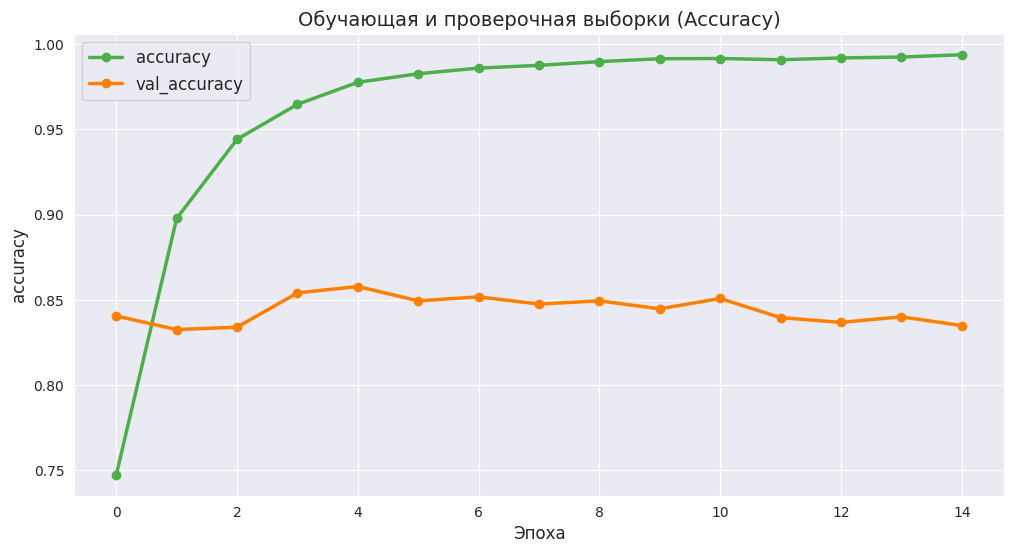

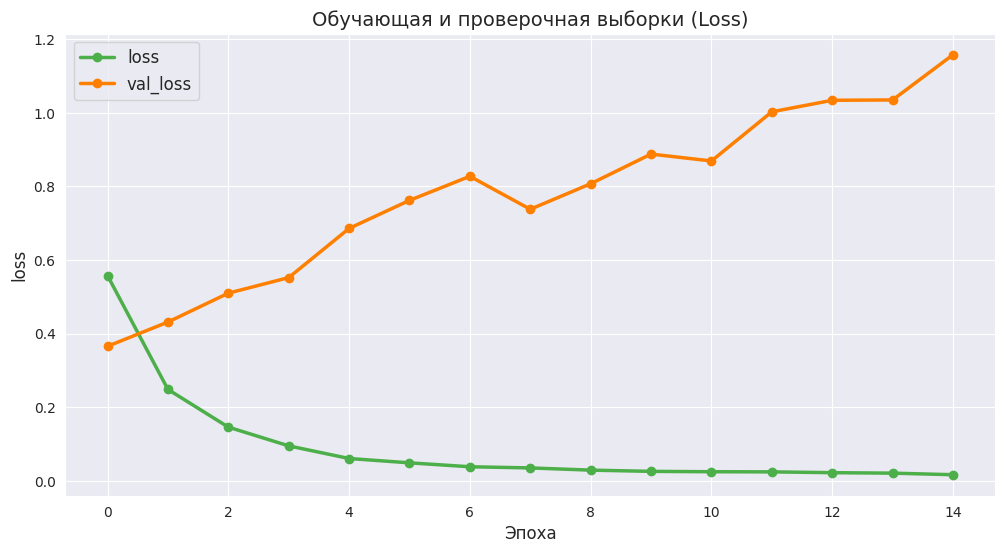

In [ ]:
plot_graphs(result_training, "accuracy")

# строим график потерь
plot_graphs(result_training, "loss")

In [ ]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1098
           1       0.81      0.88      0.85      1040

    accuracy                           0.84      2138
   macro avg       0.85      0.85      0.84      2138
weighted avg       0.85      0.84      0.84      2138



In [ ]:
# Определим функцию предсказания сарказма
def predict_sarcasm(text, model):
    # Предсказание
    result = model.predict(np.array([text]))
    if result[0] == 0:
        print("Предложение: '{}' не содержит сарказма.".format(text))
    elif result[0] == 1:
        print("Предложение : '{}' содержит сарказм.".format(text))

# Произвольные фразы, в которых мы предполагаем наличие сарказма или его отсутствие
without_sarcasm_1 = "I very like my work"
sarcasm_1 = "I very like my  fucking work"
sarcasm_2 = "Ambivalent? Well, yes and no."
sarcasm_3 = "I adore talking about nothing. It is only I can say something about."
without_sarcasm_2 = "I like cats"
# Выполняем функции
predict_sarcasm(sarcasm_1, clf)
predict_sarcasm(sarcasm_2, clf)
predict_sarcasm(sarcasm_3, clf)
predict_sarcasm(without_sarcasm_2, clf)
predict_sarcasm(without_sarcasm_1, clf)

1/1 [==============================] - 0s 9ms/step
Предложение : 'I very like my  fucking work' содержит сарказм.
1/1 [==============================] - 0s 8ms/step
Предложение: 'Ambivalent? Well, yes and no.' не содержит сарказма.
1/1 [==============================] - 0s 10ms/step
Предложение: 'I adore talking about nothing. It is only I can say something about.' не содержит сарказма.
1/1 [==============================] - 0s 8ms/step
Предложение : 'I like cats' содержит сарказм.
1/1 [==============================] - 0s 8ms/step
Предложение: 'I very like my work' не содержит сарказма.


In [ ]:
# Входной слой обработки текста (векторизация)
input_node = ak.TextInput()
# Здесь идет подбор слоев для работы с текстом
output_node = ak.TextBlock()(input_node)
# Выходной слой должен обеспечивать классификацию
output_node = ak.ClassificationHead()(output_node)
# Собираем модель, аналогично как мы это делали для Keras functional API, используем 2 модели (max_trials=2)
clf_2 = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True,  max_trials=3, objective='val_accuracy'
)
# Обучаем 2 пободранных модели на 10 эпохах
res_2 = clf_2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 3 Complete [00h 01m 22s]
val_accuracy: 0.8507951498031616

Best val_accuracy So Far: 0.857343316078186
Total elapsed time: 00h 04m 18s
Epoch 1/10
758/758 [==============================] - 16s 18ms/step - loss: 0.4785 - accuracy: 0.7547 - val_loss: 0.3507 - val_accuracy: 0.8461
Epoch 2/10
758/758 [==============================] - 6s 8ms/step - loss: 0.2847 - accuracy: 0.8836 - val_loss: 0.3512 - val_accuracy: 0.8475
Epoch 3/10
758/758 [==============================] - 5s 7ms/step - loss: 0.2013 - accuracy: 0.9231 - val_loss: 0.4321 - val_accuracy: 0.8354
Epoch 4/10
758/758 [==============================] - 6s 8ms/step - loss: 0.1501 - accuracy: 0.9441 - val_loss: 0.4490 - val_accuracy: 0.8312
Epoch 5/10
758/758 [==============================] - 5s 7ms/step - loss: 0.1145 - accuracy: 0.9578 - val_loss: 0.6026 - val_accuracy: 0.8419
Epoch 6/10
758/758 [==============================] - 5s 7ms/step - loss: 0.0894 - accuracy: 0.9684 - val_loss: 0.6533 - val_accuracy: 0.8414
Epoch

In [ ]:
clf_2.export_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLas  (None, 1)                 0         
 tDim)                                                           
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 64, 128)           640128    
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 62, 32)            12320 

In [ ]:
predict_sarcasm(sarcasm_1, clf_2)
predict_sarcasm(sarcasm_2, clf_2)
predict_sarcasm(sarcasm_3, clf_2)
predict_sarcasm(without_sarcasm_2, clf_2)
predict_sarcasm(without_sarcasm_1, clf_2)

1/1 [==============================] - 0s 11ms/step
Предложение : 'I very like my  fucking work' содержит сарказм.
1/1 [==============================] - 0s 23ms/step
Предложение: 'Ambivalent? Well, yes and no.' не содержит сарказма.
1/1 [==============================] - 0s 7ms/step
Предложение: 'I adore talking about nothing. It is only I can say something about.' не содержит сарказма.
1/1 [==============================] - 0s 7ms/step
Предложение: 'I like cats' не содержит сарказма.
1/1 [==============================] - 0s 6ms/step
Предложение: 'I very like my work' не содержит сарказма.


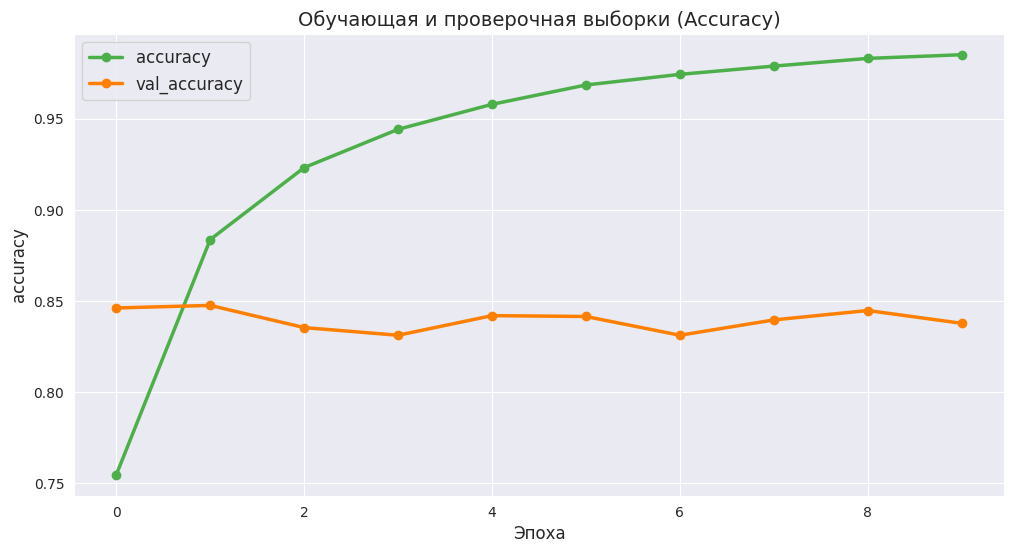

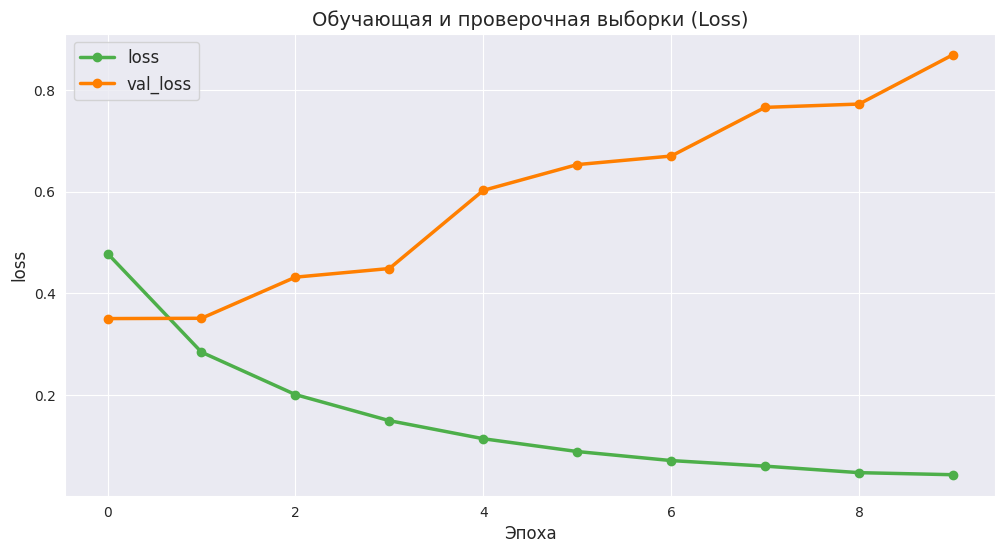

In [ ]:
plot_graphs(res_2, "accuracy")

# строим график потерь
plot_graphs(res_2, "loss")

In [ ]:
predicted_y = clf_2.predict(X_test)

# Оценка лучшей модели на тестовых данных
print(clf.evaluate(X_test, y_test))

67/67 [==============================] - 1s 9ms/step - loss: 1.0484 - accuracy: 0.8447
[1.04842209815979, 0.8447147011756897]


In [ ]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1098
           1       0.85      0.82      0.83      1040

    accuracy                           0.84      2138
   macro avg       0.84      0.84      0.84      2138
weighted avg       0.84      0.84      0.84      2138



# **Точность далека от 90%, да и с определением сарказма модель в целом справляется не очень хорошо, судя по всему она цепляется за определенную последовательность фраз и делает по ней прогноз, а значит читает "между строк не очень то хорошо", повышение числа моделей выбивает из колаба из-за нехватки памяти, повышение эпох, особого результата не дает, в целом automl фишка может и крутая, но как оказалось, требует много ресурсов и времени**